# 1. Загрузка и предобработка данных

In [39]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных из CSV-файла
data = pd.read_csv('./raai_school_2024.csv', delimiter=';')

# Преобразование столбца payment_period в формат даты
data['payment_period'] = pd.to_datetime(data['payment_period'], format='%Y-%m-%d')

# Заполнение пропусков медианными значениями для количественных переменных
imputer = SimpleImputer(strategy='median')
data[['income', 'debt', 'raised', 'volume_cold', 'volume_hot', 'volume_electr']] = imputer.fit_transform(data[['income', 'debt', 'raised', 'volume_cold', 'volume_hot', 'volume_electr']])

# Удаление выбросов для количественных переменных
for column in ['income', 'debt', 'raised', 'volume_cold', 'volume_hot', 'volume_electr']:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

data

,house_tkn,flat_tkn,payment_period,income,debt,raised,volume_cold,volume_hot,volume_electr
8,2,23180,2023-08-01,1078.19,0.00,0.00,7.55,2.61415,117.97
49,2,23219,2023-09-01,1309.31,0.00,1382.77,7.00,3.20100,163.00
59,2,23468,2023-01-01,970.61,0.00,744.61,2.10,1.92060,173.00
61,2,23468,2023-04-01,945.09,0.00,712.60,2.63,1.84591,167.34
63,2,23468,2023-07-01,1002.31,0.00,1085.26,3.00,2.13400,166.00
...,...,...,...,...,...,...,...,...,...
3206071,184543,174892,2023-02-01,217.01,0.00,78.15,7.72,2.65500,123.00
3206074,184543,174892,2023-06-01,59.03,118.06,0.00,2.10,2.65500,123.00
3206075,184543,174892,2023-07-01,0.00,177.09,0.00,5.00,2.65500,123.00
3206076,184543,174892,2023-09-01,773.17,0.00,173.12,7.72,2.65500,176.00


# 2. Определение типов поведения

Критерии:

- Давно ли проживает: рассчитываем количество месяцев от первого платежа.
- Активное потребление: рассчитываем среднее потребление воды и электричества.
- Стабильность платежей: оцениваем наличие долгов.

   house_tkn  flat_tkn payment_period   income  debt   raised  volume_cold  \
0          2     23180     2023-08-01  1078.19   0.0     0.00         7.55   
1          2     23219     2023-09-01  1309.31   0.0  1382.77         7.00   
2          2     23468     2023-01-01   970.61   0.0   744.61         2.10   
3          2     23468     2023-01-01   970.61   0.0   744.61         2.10   
4          2     23468     2023-01-01   970.61   0.0   744.61         2.10   

   volume_hot  volume_electr  months_resided  avg_volume_cold  avg_volume_hot  \
0     2.61415         117.97               0            7.550        2.614150   
1     3.20100         163.00               0            7.000        3.201000   
2     1.92060         173.00              10            2.632        1.905662   
3     1.92060         173.00              10            2.632        1.905662   
4     1.92060         173.00              10            2.632        1.905662   

   avg_volume_electr  avg_debt  term  consum

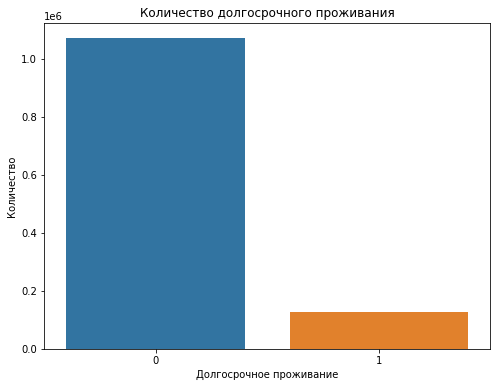

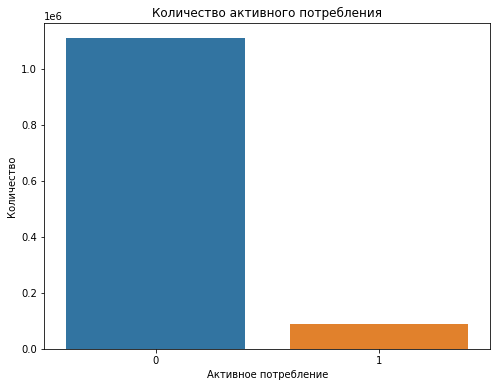

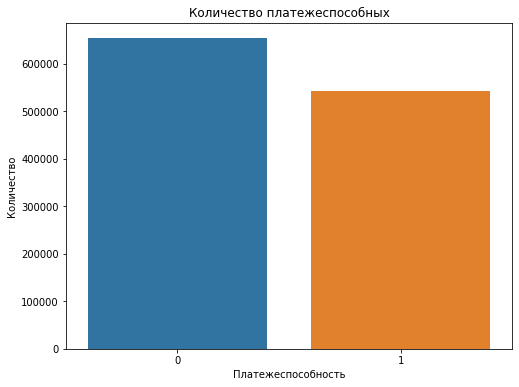

In [40]:
# Расчет времени проживания в месяцах
data['months_resided'] = data.groupby('flat_tkn')['payment_period'].transform(lambda x: (x.max() - x.min()).days // 30)

# Расчет среднего потребления воды и электричества
data['avg_volume_cold'] = data.groupby('flat_tkn')['volume_cold'].transform('mean')
data['avg_volume_hot'] = data.groupby('flat_tkn')['volume_hot'].transform('mean')
data['avg_volume_electr'] = data.groupby('flat_tkn')['volume_electr'].transform('mean')

# Расчет средней задолженности
data['avg_debt'] = data.groupby('flat_tkn')['debt'].transform('mean')

data_for_classifying = data.copy()

# Удаление лишних столбцов, которые больше не нужны для классификации
data_for_classifying.drop(['house_tkn', 'payment_period', 'volume_cold', 'volume_hot', 'volume_electr'], axis=1, inplace=True)

# Удаление дубликатов после преобразований
data_for_classifying.drop_duplicates(inplace=True)

# Проверка и удаление строк с пропусками
data_for_classifying.dropna(inplace=True)

# Функция для определения классов для каждой квартиры
def classify_apartment(mean_avg_volume_cold, mean_avg_volume_hot, mean_avg_volume_electr):
    def classify(row):
        classes = {'term': -1, 'consume': -1, 'payment': -1}
        
        # Класс "Долгосрочное проживание"
        if row['months_resided'] >= 4:
            classes['term'] = 0
        else:
            classes['term'] = 1
        
        # Класс "Активное потребление"
        if (row['avg_volume_cold'] > mean_avg_volume_cold) or (row['avg_volume_hot'] > mean_avg_volume_hot) or (row['avg_volume_electr'] > mean_avg_volume_electr):
            classes['consume'] = 0
        else:
            classes['consume'] = 1

        # Класс "Платежеспособность"
        if row['avg_debt'] <= 0:
            classes['payment'] = 0
        else:
            classes['payment'] = 1

        return pd.Series(classes)
    return classify


mean_avg_volume_cold = data_for_classifying['avg_volume_cold'].mean()
mean_avg_volume_hot = data_for_classifying['avg_volume_hot'].mean()
mean_avg_volume_electr = data_for_classifying['avg_volume_electr'].mean()
# Применение функции к данным
data_classes = data_for_classifying.apply(classify_apartment(mean_avg_volume_cold, mean_avg_volume_hot, mean_avg_volume_electr), axis=1)

# Добавление столбцов с классами к исходным данным
data_with_classes = pd.concat([data_for_classifying, data_classes], axis=1)

# Слияние данных по flat_tkn
final_data = data.merge(data_with_classes[['flat_tkn', 'term', 'consume', 'payment']], on='flat_tkn', how='left')

# Просмотр результатов
print(final_data.head())

# Построение диаграмм по количеству каждого типа поведения
plt.figure(figsize=(8, 6))
sns.countplot(data=data_with_classes, x='term')
plt.title('Количество долгосрочного проживания')
plt.xlabel('Долгосрочное проживание')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=data_with_classes, x='consume')
plt.title('Количество активного потребления')
plt.xlabel('Активное потребление')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=data_with_classes, x='payment')
plt.title('Количество платежеспособных')
plt.xlabel('Платежеспособность')
plt.ylabel('Количество')
plt.show()

# 3. Построение классификатора

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Создание обучающих и тестовых наборов данных для каждого класса
features = ['months_resided', 'avg_volume_cold', 'avg_volume_hot', 'avg_volume_electr', 'avg_debt']

# Масштабирование признаков
scaler = StandardScaler()
data_with_classes[features] = scaler.fit_transform(data_with_classes[features])

# Кросс-валидация и проверка баланса классов

# Классификатор для класса 'term'
X = data_with_classes[features]
y = data_with_classes['term']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
clf_term = RandomForestClassifier(random_state=42)
scores_term = cross_val_score(clf_term, X_res, y_res, cv=5)
print(f'Term Classifier Cross-Validation Accuracy: {scores_term.mean()}')

# Классификатор для класса 'consume'
y = data_with_classes['consume']
X_res, y_res = smote.fit_resample(X, y)
clf_consume = RandomForestClassifier(random_state=42)
scores_consume = cross_val_score(clf_consume, X_res, y_res, cv=5)
print(f'Consume Classifier Cross-Validation Accuracy: {scores_consume.mean()}')

# Классификатор для класса 'payment'
y = data_with_classes['payment']
X_res, y_res = smote.fit_resample(X, y)
clf_payment = RandomForestClassifier(random_state=42)
scores_payment = cross_val_score(clf_payment, X_res, y_res, cv=5)
print(f'Payment Classifier Cross-Validation Accuracy: {scores_payment.mean()}')

Term Classifier Cross-Validation Accuracy: 1.0
Consume Classifier Cross-Validation Accuracy: 1.0
Payment Classifier Cross-Validation Accuracy: 1.0


In [43]:
import joblib

joblib.dump(clf_term, 'term.pkl')
joblib.dump(clf_consume, 'consume.pkl')
joblib.dump(clf_payment, 'payment.pkl')

['payment.pkl']